<a href="https://colab.research.google.com/github/rudraxx/pytorch/blob/main/06_VAE_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
# https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from sklearn.manifold import TSNE
# from umap import UMAP
import umap




In [80]:
device='cuda' if torch.cuda.is_available() else 'cpu'

print(device)



cuda


In [81]:
# !pip install umap-learn

In [82]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

In [83]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [84]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [85]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


In [86]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [87]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [88]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [89]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


	Epoch 1 complete! 	Average Loss:  174.50013023007097
	Epoch 2 complete! 	Average Loss:  129.36866411467028
	Epoch 3 complete! 	Average Loss:  117.00108060960977
	Epoch 4 complete! 	Average Loss:  112.50506827785892
	Epoch 5 complete! 	Average Loss:  110.00590477945012
	Epoch 6 complete! 	Average Loss:  108.26665714015547
	Epoch 7 complete! 	Average Loss:  107.1779036023581
	Epoch 8 complete! 	Average Loss:  106.2563215711081
	Epoch 9 complete! 	Average Loss:  105.61490227853714
	Epoch 10 complete! 	Average Loss:  104.9451356427379
	Epoch 11 complete! 	Average Loss:  104.48109523359244
	Epoch 12 complete! 	Average Loss:  104.06872202368531
	Epoch 13 complete! 	Average Loss:  103.55241429400563
	Epoch 14 complete! 	Average Loss:  103.20198155780467
	Epoch 15 complete! 	Average Loss:  102.84747112700856
	Epoch 16 complete! 	Average Loss:  102.63224723497495
	Epoch 17 complete! 	Average Loss:  102.3206476125574
	Epoch 18 complete! 	Average Loss:  102.11342162066987
	Epoch 19 complete! 	Av

In [90]:
import matplotlib.pyplot as plt
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break

def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())



  0%|          | 0/100 [00:00<?, ?it/s]


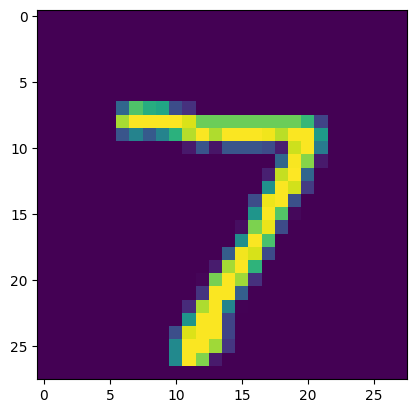

In [91]:

show_image(x, idx=0)


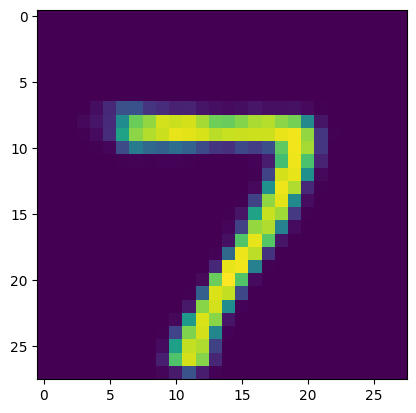

In [92]:
show_image(x_hat, idx=0)


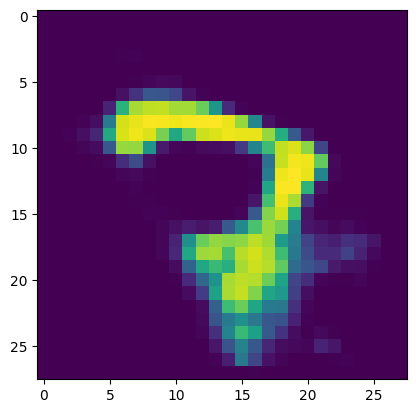

In [93]:
#Step 6. Generate image from noise vector

with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')
show_image(generated_images, idx=12)

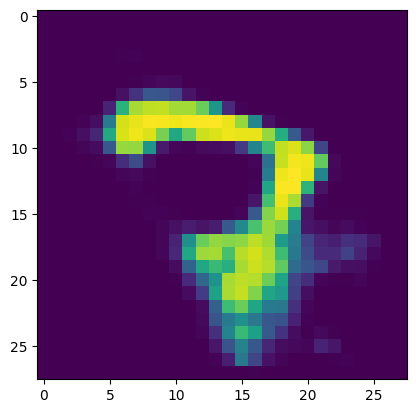

In [94]:
show_image(generated_images, idx=12)


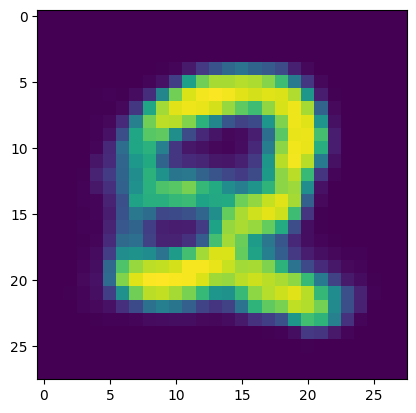

In [95]:
show_image(generated_images, idx=0)


In [96]:
def show_images_grid(images, title):

  res = make_grid(images,nrow=12)
  res = res.permute(1,2,0)

  plt.figure(figsize=(10,10))
  plt.imshow(res)
  plt.show()
  plt.title(title)

In [97]:
import plotly.express as px

def visualize_latent_space(model, data_loader, device, method='TSNE', num_samples=10000):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for i, (data, label) in enumerate(data_loader):
          if len(latents) > num_samples:
            break
          print(f"i:", i, "len(latents)", len(latents))
          data = data.view(batch_size, x_dim)

          # print(f"data.shape:", data.shape)
          # mu, _ = encoder(data.to(device))
          x_hat, mu, log_var = model(data.to(device))
          # print(f"sizes:", x_hat.shape, mu.shape, log_var.shape)

          latents.append(mu.cpu())
          labels.append(label.cpu())

    latents = torch.cat(latents, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    assert method in ['TSNE', 'UMAP'], 'method should be TSNE or UMAP'
    if method == 'TSNE':
        tsne = TSNE(n_components=2, verbose=1)
        tsne_results = tsne.fit_transform(latents)
        fig = px.scatter(tsne_results, x=0, y=1, color=labels, labels={'color': 'label'})
        fig.update_layout(title='VAE Latent Space with TSNE',
                          width=600,
                          height=600)
    elif method == 'UMAP':
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(latents)
        fig = px.scatter(embedding, x=0, y=1, color=labels, labels={'color': 'label'})

        fig.update_layout(title='VAE Latent Space with UMAP',
                          width=600,
                          height=600
                          )

    fig.show()


In [98]:
visualize_latent_space(model, train_loader,
                       device=device,
                       method='UMAP', num_samples=10000)



i: 0 len(latents) 0
i: 1 len(latents) 1
i: 2 len(latents) 2
i: 3 len(latents) 3
i: 4 len(latents) 4
i: 5 len(latents) 5
i: 6 len(latents) 6
i: 7 len(latents) 7
i: 8 len(latents) 8
i: 9 len(latents) 9
i: 10 len(latents) 10
i: 11 len(latents) 11
i: 12 len(latents) 12
i: 13 len(latents) 13
i: 14 len(latents) 14
i: 15 len(latents) 15
i: 16 len(latents) 16
i: 17 len(latents) 17
i: 18 len(latents) 18
i: 19 len(latents) 19
i: 20 len(latents) 20
i: 21 len(latents) 21
i: 22 len(latents) 22
i: 23 len(latents) 23
i: 24 len(latents) 24
i: 25 len(latents) 25
i: 26 len(latents) 26
i: 27 len(latents) 27
i: 28 len(latents) 28
i: 29 len(latents) 29
i: 30 len(latents) 30
i: 31 len(latents) 31
i: 32 len(latents) 32
i: 33 len(latents) 33
i: 34 len(latents) 34
i: 35 len(latents) 35
i: 36 len(latents) 36
i: 37 len(latents) 37
i: 38 len(latents) 38
i: 39 len(latents) 39
i: 40 len(latents) 40
i: 41 len(latents) 41
i: 42 len(latents) 42
i: 43 len(latents) 43
i: 44 len(latents) 44
i: 45 len(latents) 45
i: 46 le